<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# **Space X  Falcon 9 First Stage Landing Prediction**


## Web scraping Falcon 9 and Falcon Heavy Launches Records from Wikipedia


Estimated time needed: **40** minutes


In this lab, you will be performing web scraping to collect Falcon 9 historical launch records from a Wikipedia page titled `List of Falcon 9 and Falcon Heavy launches`

https://en.wikipedia.org/wiki/List_of_Falcon_9_and_Falcon_Heavy_launches


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_1_L2/images/Falcon9_rocket_family.svg)


Falcon 9 first stage will land successfully


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


More specifically, the launch records are stored in a HTML table shown below:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_1_L2/images/falcon9-launches-wiki.png)


  ## Objectives
Web scrap Falcon 9 launch records with `BeautifulSoup`: 
- Extract a Falcon 9 launch records HTML table from Wikipedia
- Parse the table and convert it into a Pandas data frame


First let's import required packages for this lab


In [ ]:
!pip3 install beautifulsoup4
!pip3 install requests

In [2]:
import sys

import requests
from bs4 import BeautifulSoup
import re
import unicodedata
import pandas as pd

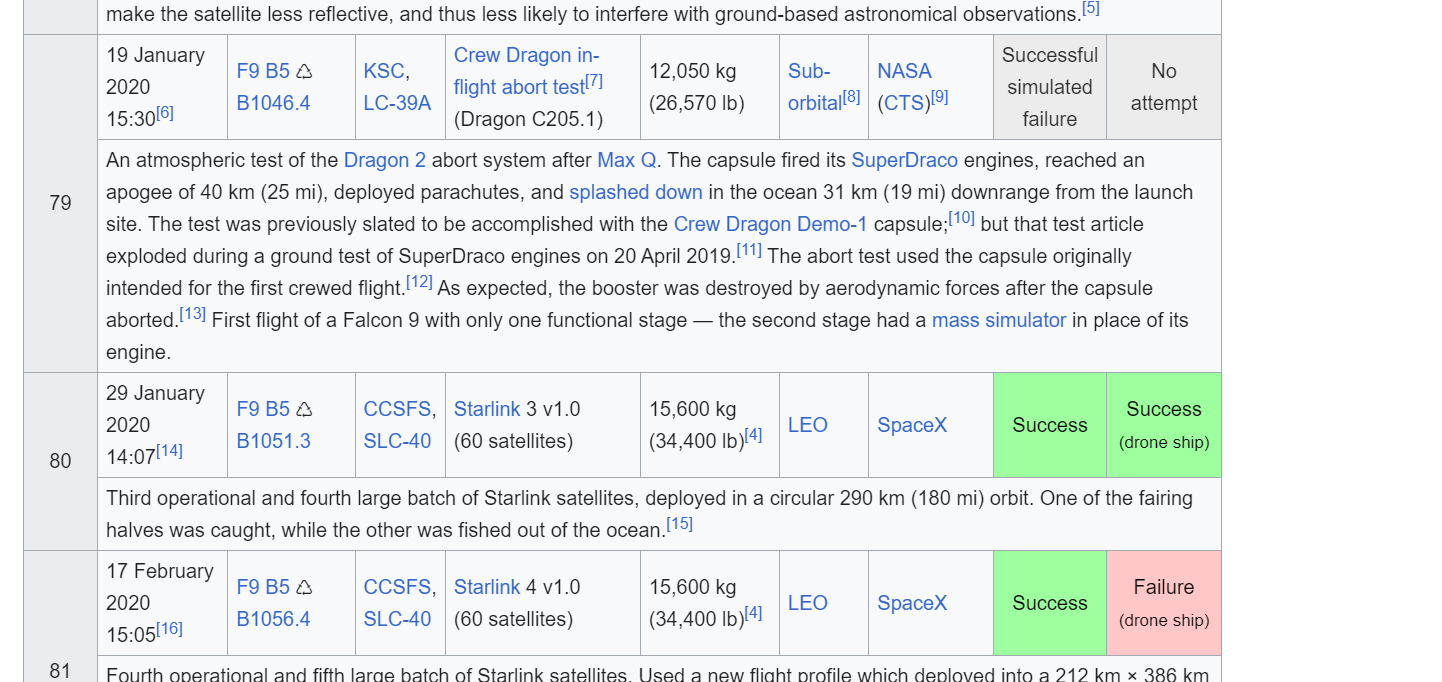

and we will provide some helper functions for you to process web scraped HTML table


In [3]:
def date_time(table_cells):
    """
    This function returns the data and time from the HTML  table cell
    Input: the  element of a table data cell extracts extra row
    """
    return [data_time.strip() for data_time in list(table_cells.strings)][0:2]

def booster_version(table_cells):
    """
    This function returns the booster version from the HTML  table cell 
    Input: the  element of a table data cell extracts extra row
    """
    out=''.join([booster_version for i,booster_version in enumerate( table_cells.strings) if i%2==0][0:-1]) #only look at even-number rows as there is just text in uneven number rows
    return out

def landing_status(table_cells):
    """
    This function returns the landing status from the HTML table cell 
    Input: the  element of a table data cell extracts extra row
    """
    out=[i for i in table_cells.strings][0]
    return out


def get_mass(table_cells):
    mass=unicodedata.normalize("NFKD", table_cells.text).strip()
    if mass:
        mass.find("kg")
        new_mass=mass[0:mass.find("kg")+2] #take the string from the beginning to the place where there is 'kg' written
    else:
        new_mass=0
    return new_mass


def extract_column_from_header(row):
    """
    This function returns the landing status from the HTML table cell 
    Input: the  element of a table data cell extracts extra row
    """
    if (row.br):
        row.br.extract()
    if row.a:
        row.a.extract()
    if row.sup:
        row.sup.extract()
        
    colunm_name = ' '.join(row.contents)
    
    # Filter the digit and empty names
    if not(colunm_name.strip().isdigit()):
        colunm_name = colunm_name.strip()
        return colunm_name    


To keep the lab tasks consistent, you will be asked to scrape the data from a snapshot of the  `List of Falcon 9 and Falcon Heavy launches` Wikipage updated on
`9th June 2021`


In [4]:
static_url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"

Next, request the HTML page from the above URL and get a `response` object


### TASK 1: Request the Falcon9 Launch Wiki page from its URL


First, let's perform an HTTP GET method to request the Falcon9 Launch HTML page, as an HTTP response.


In [5]:
# use requests.get() method with the provided static_url
# assign the response to a object
data=requests.get(static_url).text

Create a `BeautifulSoup` object from the HTML `response`


In [6]:
# Use BeautifulSoup() to create a BeautifulSoup object from a response text content
soup=BeautifulSoup(data)

Print the page title to verify if the `BeautifulSoup` object was created properly 


In [7]:
# Use soup.title attribute
soup.title

<title>List of Falcon 9 and Falcon Heavy launches - Wikipedia</title>

### TASK 2: Extract all column/variable names from the HTML table header


Next, we want to collect all relevant column names from the HTML table header


Let's try to find all tables on the wiki page first. If you need to refresh your memory about `BeautifulSoup`, please check the external reference link towards the end of this lab


In [15]:
# Use the find_all function in the BeautifulSoup object, with element type `table`
# Assign the result to a list called `html_tables`
html_tables = soup.find_all('table')
print(html_tables)


[<table class="col-begin" role="presentation">
<tbody><tr>
<td class="col-break">
<div class="mw-heading mw-heading3"><h3 id="Rocket_configurations">Rocket configurations</h3></div>
<div class="chart noresize" style="padding-top:10px;margin-top:1em;max-width:420px;">
<div style="position:relative;min-height:320px;min-width:420px;max-width:420px;">
<div style="float:right;position:relative;min-height:240px;min-width:320px;max-width:320px;border-left:1px black solid;border-bottom:1px black solid;">
<div style="position:absolute;left:3px;top:224px;height:15px;min-width:18px;max-width:18px;background-color:LightSteelBlue;-webkit-print-color-adjust:exact;border:1px solid LightSteelBlue;border-bottom:none;overflow:hidden;" title="[[Falcon 9 v1.0]]: 2"></div>
<div style="position:absolute;left:55px;top:224px;height:15px;min-width:18px;max-width:18px;background-color:LightSteelBlue;-webkit-print-color-adjust:exact;border:1px solid LightSteelBlue;border-bottom:none;overflow:hidden;" title="[[Fa

Starting from the third table is our target table contains the actual launch records.


In [16]:
# Let's print the third table and check its content
first_launch_table = html_tables[2]
print(first_launch_table)

<table class="wikitable plainrowheaders collapsible" style="width: 100%;">
<tbody><tr>
<th scope="col">Flight No.
</th>
<th scope="col">Date andtime ()
</th>
<th scope="col"> 
</th>
<th scope="col">Launch site
</th>
<th scope="col">Payload
</th>
<th scope="col">Payload mass
</th>
<th scope="col">Orbit
</th>
<th scope="col">Customer
</th>
<th scope="col">Launchoutcome
</th>
<th scope="col">
</th></tr>
<tr>
<th rowspan="2" scope="row" style="text-align:center;">1
</th>
<td>4 June 2010,<br/>18:45
</td>
<td><a href="/wiki/Falcon_9_v1.0" title="Falcon 9 v1.0">F9 v1.0</a><sup class="reference" id="cite_ref-MuskMay2012_13-0"><a href="#cite_note-MuskMay2012-13">[7]</a></sup><br/>B0003.1<sup class="reference" id="cite_ref-block_numbers_14-0"><a href="#cite_note-block_numbers-14">[8]</a></sup>
</td>
<td><a href="/wiki/Cape_Canaveral_Space_Force_Station" title="Cape Canaveral Space Force Station">CCAFS</a>,<br/><a href="/wiki/Cape_Canaveral_Space_Launch_Complex_40" title="Cape Canaveral Space Lau

You should able to see the columns names embedded in the table header elements `<th>` as follows:


```
<tr>
<th scope="col">Flight No.
</th>
<th scope="col">Date and<br/>time (<a href="/wiki/Coordinated_Universal_Time" title="Coordinated Universal Time">UTC</a>)
</th>
<th scope="col"><a href="/wiki/List_of_Falcon_9_first-stage_boosters" title="List of Falcon 9 first-stage boosters">Version,<br/>Booster</a> <sup class="reference" id="cite_ref-booster_11-0"><a href="#cite_note-booster-11">[b]</a></sup>
</th>
<th scope="col">Launch site
</th>
<th scope="col">Payload<sup class="reference" id="cite_ref-Dragon_12-0"><a href="#cite_note-Dragon-12">[c]</a></sup>
</th>
<th scope="col">Payload mass
</th>
<th scope="col">Orbit
</th>
<th scope="col">Customer
</th>
<th scope="col">Launch<br/>outcome
</th>
<th scope="col"><a href="/wiki/Falcon_9_first-stage_landing_tests" title="Falcon 9 first-stage landing tests">Booster<br/>landing</a>
</th></tr>
```


Next, we just need to iterate through the `<th>` elements and apply the provided `extract_column_from_header()` to extract column name one by one


In [10]:
column_names = []
# Apply find_all() function with `th` element on first_launch_table
# Iterate each th element and apply the provided extract_column_from_header() to get a column name
# Append the Non-empty column name (`if name is not None and len(name) > 0`) into a list called column_names

    #col = row.find_all("td")


for name in first_launch_table.find_all('th'):
    header=extract_column_from_header(name)
    if header is not None and len(header.strip()) > 0:
        column_names.append(header.strip())

print(column_names)

['Flight No.', 'Date and time ( )', 'Launch site', 'Payload', 'Payload mass', 'Orbit', 'Customer', 'Launch outcome']


Check the extracted column names


In [11]:
print(column_names)

['Flight No.', 'Date and time ( )', 'Launch site', 'Payload', 'Payload mass', 'Orbit', 'Customer', 'Launch outcome']


## TASK 3: Create a data frame by parsing the launch HTML tables


We will create an empty dictionary with keys from the extracted column names in the previous task. Later, this dictionary will be converted into a Pandas dataframe


In [12]:
launch_dict= dict.fromkeys(column_names)

# Remove an irrelvant column
del launch_dict['Date and time ( )']

# Let's initial the launch_dict with each value to be an empty list
launch_dict['Flight No.'] = []
launch_dict['Launch site'] = []
launch_dict['Payload'] = []
launch_dict['Payload mass'] = []
launch_dict['Orbit'] = []
launch_dict['Customer'] = []
launch_dict['Launch outcome'] = []
# Added some new columns
launch_dict['Version Booster']=[]
launch_dict['Booster landing']=[]
launch_dict['Date']=[]
launch_dict['Time']=[]

Next, we just need to fill up the `launch_dict` with launch records extracted from table rows.


Usually, HTML tables in Wiki pages are likely to contain unexpected annotations and other types of noises, such as reference links `B0004.1[8]`, missing values `N/A [e]`, inconsistent formatting, etc.


To simplify the parsing process, we have provided an incomplete code snippet below to help you to fill up the `launch_dict`. Please complete the following code snippet with TODOs or you can choose to write your own logic to parse all launch tables:


In [13]:
extracted_row = 0
#Extract each table 
for table_number,table in enumerate(soup.find_all('table',"wikitable plainrowheaders collapsible")):
   # get table row 
    for rows in table.find_all("tr"):
        #check to see if first table heading is as number corresponding to launch a number 
        if rows.th:
            if rows.th.string:
                flight_number=rows.th.string.strip()
                flag=flight_number.isdigit()
        else:
            flag=False
        #get table element 
        row=rows.find_all('td')
        #if it is number save cells in a dictonary 
        if flag:
            extracted_row += 1
            # Flight Number value
            # DONE: Append the flight_number into launch_dict with key `Flight No.`
            launch_dict['Flight No.'].append(flight_number)
            #print(flight_number)
            datatimelist=date_time(row[0])
            
            # Date value
            # TODO: Append the date into launch_dict with key `Date`
            date = datatimelist[0].strip(',')
            launch_dict['Date'].append(date)
            #print(date)
            
            # Time value
            # TODO: Append the time into launch_dict with key `Time`
            time = datatimelist[1]
            launch_dict['Time'].append(time)
            #print(time)
              
            # Booster version
            # TODO: Append the bv into launch_dict with key `Version Booster`
            bv=booster_version(row[1])
            if not(bv):
                bv=row[1].a.string
                launch_dict['Version Booster'].append(bv)
            #print(bv)
            
            # Launch Site
            # TODO: Append the bv into launch_dict with key `Launch Site`
            launch_site = row[2].a.string
            launch_dict['Launch site'].append(launch_site)
            #print(launch_site)
            
            # Payload
            # TODO: Append the payload into launch_dict with key `Payload`
            payload = row[3].a.string
            launch_dict['Payload'].append(payload)
            #print(payload)
            
            # Payload Mass
            # TODO: Append the payload_mass into launch_dict with key `Payload mass`
            payload_mass = get_mass(row[4])
            launch_dict['Payload mass'].append(payload_mass)
            #print(payload)
            
            # Orbit
            # TODO: Append the orbit into launch_dict with key `Orbit`
            orbit = row[5].a.string
            launch_dict['Orbit'].append(orbit)
            #print(orbit)
            
            # Customer
            # TODO: Append the customer into launch_dict with key `Customer`
            if row[6].a is not None:
                customer = row[6].a.string
                launch_dict['Customer'].append(customer)
            else:
                launch_dict['Customer'].append(row[6].a)
            #print(customer)
            
            # Launch outcome
            # TODO: Append the launch_outcome into launch_dict with key `Launch outcome`
            launch_outcome = list(row[7].strings)[0]
            launch_dict['Launch outcome'].append(launch_outcome)
            #print(launch_outcome)
            
            # Booster landing
            # TODO: Append the launch_outcome into launch_dict with key `Booster landing`
            booster_landing = landing_status(row[8])
            launch_dict['Booster landing'].append(booster_landing)
            #print(booster_landing)
            

After you have fill in the parsed launch record values into `launch_dict`, you can create a dataframe from it.


In [14]:
df= pd.DataFrame({ key:pd.Series(value) for key, value in launch_dict.items() })
df

,Flight No.,Launch site,Payload,Payload mass,Orbit,Customer,Launch outcome,Version Booster,Booster landing,Date,Time
0,1,CCAFS,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success\n,F9 v1.1,Failure,4 June 2010,18:45
1,2,CCAFS,Dragon,0,LEO,NASA,Success,F9 v1.1,Failure,8 December 2010,15:43
2,3,CCAFS,Dragon,525 kg,LEO,NASA,Success,F9 v1.1,No attempt\n,22 May 2012,07:44
3,4,CCAFS,SpaceX CRS-1,"4,700 kg",LEO,NASA,Success\n,F9 v1.1,No attempt,8 October 2012,00:35
4,5,CCAFS,SpaceX CRS-2,"4,877 kg",LEO,NASA,Success\n,F9 v1.1,No attempt\n,1 March 2013,15:10
...,...,...,...,...,...,...,...,...,...,...,...
116,117,CCSFS,Starlink,"15,600 kg",LEO,SpaceX,Success\n,NaN,Success,9 May 2021,06:42
117,118,KSC,Starlink,"~14,000 kg",LEO,SpaceX,Success\n,NaN,Success,15 May 2021,22:56
118,119,CCSFS,Starlink,"15,600 kg",LEO,SpaceX,Success\n,NaN,Success,26 May 2021,18:59
119,120,KSC,SpaceX CRS-22,"3,328 kg",LEO,NASA,Success\n,NaN,Success,3 June 2021,17:29


We can now export it to a <b>CSV</b> for the next section, but to make the answers consistent and in case you have difficulties finishing this lab. 

Following labs will be using a provided dataset to make each lab independent. 


<code>df.to_csv('spacex_web_scraped.csv', index=False)</code>


## Authors


<a href="https://www.linkedin.com/in/yan-luo-96288783/">Yan Luo</a>


<a href="https://www.linkedin.com/in/nayefaboutayoun/">Nayef Abou Tayoun</a>


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By | Change Description      |
| ----------------- | ------- | ---------- | ----------------------- |
| 2021-06-09        | 1.0     | Yan Luo    | Tasks updates           |
| 2020-11-10        | 1.0     | Nayef      | Created the initial version |


Copyright © 2021 IBM Corporation. All rights reserved.
